## 30 July 2018
-- Laurin Gray

Making a 3-sigma curve down a CMD. We flag any object rightward of the 3-sigma line "of interest". If a source is flagged in multiple CMDs, we can be more confident that it is an AGB star.

The approach in this notebook is to sort y-values, x-values, error values, and IDs into separate bins/arrays, grouped by magnitude ranges. We sort by magnitude because as the source becomes dimmer, the error associated with it increases. We determine the 3-sigma value for each range, and an average line down the main vertical branch to be 3-sigma away from. We then identify any value that is higher than the 3-sigma boundary for the region it falls into and place the corresponding ID into a new array, which can be compared to other arrays to determine which ones are flagged in multiple CMDs.

This notebook contains functions to facilitate this flagging.  This notebook is also a remake of 23July2018_3SigFlagging, combining errors in quadrature rather than just adding them together.

The data comes from the catalog of Spitzer sources of Khan et al. (2015), matched with sources from Whitelock et al. (2013) in CasJobs.

List of CMDs used:
- [3.6] vs. J-[3.6]
- [8.0] vs. [3.6]-[8.0]
- [8.0] vs. [4.5]-[8.0]
- H vs. J-H
- H vs. H-[3.6]
- H vs. H-[4.5]
- K vs. J-K
- K vs. H-K

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
import csv
import pathlib

In [2]:
# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')

In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSfourfive'] = phot_data.k36mag.values - phot_data.k45mag.values
phot_data['threesixMINUSfiveeight'] = phot_data.k36mag.values - phot_data.k58mag.values
phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
phot_data['threesixMINUStwentyfour'] = phot_data.k36mag.values - phot_data.k24mag.values
#
phot_data['fourfiveMINUSfiveeight'] = phot_data.k45mag.values - phot_data.k58mag.values
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
phot_data['fourfiveMINUStwentyfour'] = phot_data.k45mag.values - phot_data.k24mag.values
#
phot_data['fiveeightMINUSeightzero'] = phot_data.k58mag.values - phot_data.k80mag.values
phot_data['fiveeightMINUStwentyfour'] = phot_data.k58mag.values - phot_data.k24mag.values
#
phot_data['eightzeroMINUStwentyfour'] = phot_data.k80mag.values - phot_data.k24mag.values
#
phot_data['jMINUSthreesix'] = phot_data.Jmag.values - phot_data.k36mag.values
phot_data['jMINUSfourfive'] = phot_data.Jmag.values - phot_data.k45mag.values
phot_data['jMINUSfiveeight'] = phot_data.Jmag.values - phot_data.k58mag.values
phot_data['jMINUSeightzero'] = phot_data.Jmag.values - phot_data.k80mag.values
phot_data['jMINUStwentyfour'] = phot_data.Jmag.values - phot_data.k24mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values
phot_data['hMINUSfiveeight'] = phot_data.Hmag.values - phot_data.k58mag.values
phot_data['hMINUSeightzero'] = phot_data.Hmag.values - phot_data.k80mag.values
phot_data['hMINUStwentyfour'] = phot_data.Hmag.values - phot_data.k24mag.values
#
phot_data['kMINUSthreesix'] = phot_data.Kmag.values - phot_data.k36mag.values
phot_data['kMINUSfourfive'] = phot_data.Kmag.values - phot_data.k45mag.values
phot_data['kMINUSfiveeight'] = phot_data.Kmag.values - phot_data.k58mag.values
phot_data['kMINUSeightzero'] = phot_data.Kmag.values - phot_data.k80mag.values
phot_data['kMINUStwentyfour'] = phot_data.Kmag.values - phot_data.k24mag.values

In [4]:
def error_prop(a, b):
    err = []
    c=0
    for i in a:
        a2 = i**2
        b2 = b[c]**2
        c = c+1
        error = (a2 + b2)**0.5
        err.append(error)
    
    return err

In [5]:
# Combine errors

# We want the horizontal error values, so we combine the errors for the two values being subtracted 
# to get the largest possible error bars

# I'm going to go ahead and just create all the error combinations based on possible color cuts

phot_data['e_threesixMINUSfourfive'] = error_prop(phot_data.e36mag.values, phot_data.e45mag.values)
phot_data['e_threesixMINUSfiveeight'] = error_prop(phot_data.e36mag.values, phot_data.e58mag.values)
phot_data['e_threesixMINUSeightzero'] = error_prop(phot_data.e36mag.values, phot_data.e80mag.values)
phot_data['e_threesixMINUStwentyfour'] = error_prop(phot_data.e36mag.values, phot_data.e24mag.values)
#
phot_data['e_fourfiveMINUSfiveeight'] = error_prop(phot_data.e45mag.values, phot_data.e58mag.values)
phot_data['e_fourfiveMINUSeightzero'] = error_prop(phot_data.e45mag.values, phot_data.e80mag.values)
phot_data['e_fourfiveMINUStwentyfour'] = error_prop(phot_data.e45mag.values, phot_data.e24mag.values)
#
phot_data['e_fiveeightMINUSeightzero'] = error_prop(phot_data.e58mag.values, phot_data.e80mag.values)
phot_data['e_fiveeightMINUStwentyfour'] = error_prop(phot_data.e58mag.values, phot_data.e24mag.values)
#
phot_data['e_eightzeroMINUStwentyfour'] = error_prop(phot_data.e80mag.values, phot_data.e24mag.values)
#
phot_data['e_jMINUSthreesix'] = error_prop(phot_data.eJmag.values, phot_data.e36mag.values)
phot_data['e_jMINUSfourfive'] = error_prop(phot_data.eJmag.values, phot_data.e45mag.values)
phot_data['e_jMINUSfiveeight'] = error_prop(phot_data.eJmag.values, phot_data.e58mag.values)
phot_data['e_jMINUSeightzero'] = error_prop(phot_data.eJmag.values, phot_data.e80mag.values)
phot_data['e_jMINUStwentyfour'] = error_prop(phot_data.eJmag.values, phot_data.e24mag.values)
phot_data['e_jMINUSh'] = error_prop(phot_data.eJmag.values, phot_data.eHmag.values)
phot_data['e_jMINUSk'] = error_prop(phot_data.eJmag.values, phot_data.eKmag.values)
#
phot_data['e_hMINUSthreesix'] = error_prop(phot_data.eHmag.values, phot_data.e36mag.values)
phot_data['e_hMINUSfourfive'] = error_prop(phot_data.eHmag.values, phot_data.e45mag.values)
phot_data['e_hMINUSfiveeight'] = error_prop(phot_data.eHmag.values, phot_data.e58mag.values)
phot_data['e_hMINUSeightzero'] = error_prop(phot_data.eHmag.values, phot_data.e80mag.values)
phot_data['e_hMINUStwentyfour'] = error_prop(phot_data.eHmag.values, phot_data.e24mag.values)
phot_data['e_hMINUSk'] = error_prop(phot_data.eHmag.values, phot_data.eKmag.values)
#
phot_data['e_kMINUSthreesix'] = error_prop(phot_data.eKmag.values, phot_data.e36mag.values)
phot_data['e_kMINUSfourfive'] = error_prop(phot_data.eKmag.values, phot_data.e45mag.values)
phot_data['e_kMINUSfiveeight'] = error_prop(phot_data.eKmag.values, phot_data.e58mag.values)
phot_data['e_kMINUSeightzero'] = error_prop(phot_data.eKmag.values, phot_data.e80mag.values)
phot_data['e_kMINUStwentyfour'] = error_prop(phot_data.eKmag.values, phot_data.e24mag.values)

In [6]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

In [7]:
# For ease in calling functions, we rename all the value arrays to exclude filter_phot_data._____.values
# Because there's so many, I'm only defining ones I'll probably need- I can add any later

# Magnitudes
threesix = filter_phot_data.k36mag.values
fourfive = filter_phot_data.k45mag.values
fiveeight = filter_phot_data.k58mag.values
eightzero = filter_phot_data.k80mag.values
twentyfour = filter_phot_data.k24mag.values
Jmag = filter_phot_data.Jmag.values
Hmag = filter_phot_data.Hmag.values
Kmag = filter_phot_data.Kmag.values


# Colors
threesixMINUSeightzero = filter_phot_data.threesixMINUSeightzero.values

fourfiveMINUSeightzero = filter_phot_data.fourfiveMINUSeightzero.values

jMINUSthreesix = filter_phot_data.jMINUSthreesix.values
jMINUSfourfive = filter_phot_data.jMINUSfourfive.values
jMINUSeightzero = filter_phot_data.jMINUSeightzero.values
jMINUStwentyfour = filter_phot_data.jMINUStwentyfour.values
jMINUSh = filter_phot_data.jMINUSh.values
jMINUSk = filter_phot_data.jMINUSk.values

hMINUSthreesix = filter_phot_data.hMINUSthreesix.values
hMINUSfourfive = filter_phot_data.hMINUSfourfive.values
hMINUSeightzero = filter_phot_data.hMINUSeightzero.values
hMINUStwentyfour = filter_phot_data.hMINUStwentyfour.values
hMINUSk = filter_phot_data.hMINUSk.values

kMINUSthreesix = filter_phot_data.kMINUSthreesix.values
kMINUSfourfive = filter_phot_data.kMINUSfourfive.values
kMINUSfiveeight = filter_phot_data.kMINUSfiveeight.values
kMINUSeightzero = filter_phot_data.kMINUSeightzero.values
kMINUStwentyfour = filter_phot_data.kMINUStwentyfour.values


# Errors
e_threesixMINUSeightzero = filter_phot_data.e_threesixMINUSeightzero.values

e_fourfiveMINUSeightzero = filter_phot_data.e_fourfiveMINUSeightzero.values

e_jMINUSthreesix = filter_phot_data.e_jMINUSthreesix.values
e_jMINUSfourfive = filter_phot_data.e_jMINUSfourfive.values
e_jMINUSeightzero = filter_phot_data.e_jMINUSeightzero.values
e_jMINUStwentyfour = filter_phot_data.e_jMINUStwentyfour.values
e_jMINUSh = filter_phot_data.e_jMINUSh.values
e_jMINUSk = filter_phot_data.e_jMINUSk.values

e_hMINUSthreesix = filter_phot_data.e_hMINUSthreesix.values
e_hMINUSfourfive = filter_phot_data.e_hMINUSfourfive.values
e_hMINUSeightzero = filter_phot_data.e_hMINUSeightzero.values
e_hMINUStwentyfour = filter_phot_data.e_hMINUStwentyfour.values
e_hMINUSk = filter_phot_data.e_hMINUSk.values

e_kMINUSthreesix = filter_phot_data.e_kMINUSthreesix.values
e_kMINUSfourfive = filter_phot_data.e_kMINUSfourfive.values
e_kMINUSfiveeight = filter_phot_data.e_kMINUSfiveeight.values
e_kMINUSeightzero = filter_phot_data.e_kMINUSeightzero.values
e_kMINUStwentyfour = filter_phot_data.e_kMINUStwentyfour.values

## Function Definitions

In [8]:
def create_bins(bin_size, y1, y2, xval, yval, err):
    """
    Create bins to hold selected x-values, y-values, and errors, along with the coordinate ID, 
    depending on the range of y-values they fall into. Fill those bins with the values, and return the bins.
    
    The user enters the size of the bin they'd like, the range of data to cover, the x and y axes of the CMD,
    and the error associated with the x-axis (created above).  
    
    Note that it is possible to create bins that will have no values in them- these will simply hold a nan spot, 
    and not create a 3-sigma boundary for that range.
    
    The bin size and range must be chosen so that the number of bins comes out as a whole number.  
    If this is not the case, an error message will print.  
    
    y1 must be lower than y2.
    
    xval, yval, and err take the form "Kmag" or "e_kMINUSthreesix"
    
    Example of calling function:
        create_bins(0.5, 11.5, 18.5, kMINUSthreesix, Kmag, e_kMINUSthreesix)
    
    """
    
    n_bins = (y2 - y1)/bin_size
    #print(n_bins)

    if n_bins%1 == 0:
        n_bins = int(n_bins)
    else:
        print("Error: n_bins is not a whole number!  Choose a different range or bin size.")
    
    
    y_bins = [[] for x in range(0,n_bins)] # y-values
    x_bins = [[] for x in range(0,n_bins)] # x-values
    e_bins = [[] for x in range(0,n_bins)] # errors
    c_bins = [[] for x in range(0,n_bins)] # IDs

    #print(y_bins)

    c=0 #row counter
    for i in yval:
        k = 0 #bin counter
        if yval is eightzero:
            y1 = 8.0
        else:
            y1 = 11.5
        while k < n_bins:
            if y1 <= i < y1+bin_size:
                y_bins[k].append(i)
                x_bins[k].append(xval[c])
                e_bins[k].append(err[c])
                c_bins[k].append(phot_data.ID.values[c])
                y1 = y1+bin_size
                k = k+1
            else:
                y1 = y1+bin_size
                k = k+1
        c = c+1
        
    return y_bins, x_bins, e_bins, c_bins

In [9]:
def vert_mean(mag_lim, xval, yval):
    """
    Determine the vertical line of the data- the average of the vertical branch.  
    To mitigate the effects of other branches, select a mag_lim that excludes where the points diverge.
    
    Example of calling function:
        vert_mean(15.0, kMINUSthreesix, Kmag)
    """
    
    mean = []

    c=0
    for i in yval:
        if i < mag_lim:
            mean.append(xval[c])
            c = c+1
        else:
            c = c+1

    bound = np.nanmean(mean)
    stdev = np.nanstd(mean)

    left = bound - 3*stdev
    right = bound + 3*stdev

    clip = [] # sigma-clipped array
    for k in mean:
        if left < k < right:
            clip.append(k)

    boundary = np.nanmean(clip) #this is the average value of the points above K=15
    #print(boundary)
    
    return boundary

In [10]:
def bound_shift(boundary):
    """
    Create boundaries in region that are 3-sigma away from the vertical mean.  
    Input is the return of the vertical mean function.
    
    If any bins are empty, this function will return a RuntimeWarning: Mean of empty slice. 
    This is fine, it just holds a nan value in that spot and won't plot a boundary there
    
    Call example:
        bound_shift(boundary)
    """
    
    threesig = []
    for i in e_bin:
        threesig.append(np.nanmean(i)*3)
    
    # make list of red limit values
    redlim = []

    for i in threesig:
        redlim.append(boundary+i)
    
    #print(redlim)
    return redlim

In [31]:
def plot_CMD(xaxis, yaxis, color='grey'):
    """
    Plot a CMD.
    
    Note that axes limits/labels are pre-defined for the 8 CMDs that were checked.
    """
    
    # set axis limits & names (so I don't have to do it manually each time I plot)
    if yaxis is eightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
    elif yaxis is Hmag:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
    elif yaxis is Kmag:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'K'
    elif yaxis is threesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = '[3.6]'
    
    if xaxis is threesixMINUSeightzero:
        x1 = -2.0
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif xaxis is fourfiveMINUSeightzero:
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'
    elif xaxis is jMINUSthreesix:
        x1 = -0.5
        x2 = 6.0
        xlabel = 'J - [3.6]'
    elif xaxis is jMINUSh:
        x1 = -0.5
        x2 = 2.5
        xlabel = 'J - H'
    elif xaxis is hMINUSk:
        x1 = -0.5
        x2 = 2.0
        xlabel = 'H - K'
    elif xaxis is hMINUSthreesix:
        x1 = -1.5
        x2 = 4.0
        xlabel = 'H - [3.6]'
    elif xaxis is hMINUSfourfive:
        x1 = -2.5
        x2 = 5.0
        xlabel = 'H - [4.5]'
    elif xaxis is jMINUSk:
        x1 = -0.5
        x2 = 4.0
        xlabel = 'J - K'
    elif xaxis is kMINUSthreesix:
        x1 = -2.0
        x2 = 3.5
        xlabel = 'K - [3.6]'
    elif xaxis is kMINUSfourfive:
        x1 = -2.5
        x2 = 3.5
        xlabel = 'K - [4.5]'
    
    plt.figure(figsize=(12,12))
    plt.plot(xaxis,yaxis,',', color=color)
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    plt.xlabel(xlabel, size=22)
    plt.ylabel(ylabel, size=22)
    plt.tick_params(labelsize=17)

In [12]:
def data_flag():
    """
    Evaluate and flag points that are to the right of the 3-sigma boundary.  
    IDs of flagged points are then stored in a list and returned.
    
    It is suggested that when you call the function to a variable, you name it in the format kVS_kMINUSthreesix,
    as this will make it easier to tell which datasets belong to which CMDs when they are all in the same file.
    
    Call example:
        kVS_kMINUSthreesix = data_flag()
    """
    
    IDs = [] #empty set to store IDs

    k=0
    
    if yaxis is eightzero:
        for i in x_bin[:74]: 
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
    else:
        for i in x_bin:
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
            
    print("Number of flagged points:", len(IDs))
    #print("IDs of points:", IDs)
    return IDs

In [13]:
def save_data(dataset, column=''):
    """
    Check if the data file already exists.  If it does, add the data on as a new column with a 
    header you set when you call the function.  If it doesn't, create the file and add the data to it.
    
    Call example:
        save_data(jVS_jMINUSthreesix, column='jVS_jMINUSthreesix')
    """
    
    if path.exists():
        flagged_points = pd.read_csv(filename)
        new_points = pd.DataFrame({column:dataset})

        flagged_points= pd.concat([flagged_points, new_points], axis=1)
        flagged_points.to_csv(filename, index=False)
    else:
        f = open(filename, 'w')
        writer = csv.writer(f)
        #add heading
        points_w_header = [column] + dataset

        for val in points_w_header:
            writer.writerow([val])

        f.close()

## Run data

Every time you run a new set of data, make sure to change:
- y1 (below and in the create_bins definition)
- y2
- lim
- xaxis
- yaxis
- error
- column name

y1 = 8.0 for [8.0] vs. CMDs, 11.5 for other CMDs.  y2 = 18.0 for [8.0] vs. CMDs, 19.0 for other CMDs.

Lim doesn't matter for [8.0] vs. CMDs, because it will be set manually.  Lim for [3.6] vs. J-[3.6] & K vs. H-K is 14.0, lim for H vs. J-H & K vs. J-K is 14.5, lim for H vs. H-[3.6] & H vs. H-[4.5] is 15.0

In [14]:
filename = '/Users/lgray/Documents/Phot_data/flagged_vals_30July2018_lauringray.csv'
path = pathlib.Path(filename)

y1 = 11.5 #make sure to change in create_bins definition
y2 = 19.0
bin_size = 0.1
lim = 14.5
xaxis = jMINUSk
yaxis = Kmag
error = e_jMINUSk
column = 'kVS_jMINUSk'

y_bin, x_bin, e_bin, c_bin = create_bins(bin_size, y1, y2, xaxis, yaxis, error)

#print(y_bin[74])

In [15]:
boundary = vert_mean(lim, xaxis, yaxis)

# the [8.0] vs. CMDs have manually set vertical means
if xaxis is threesixMINUSeightzero:
    boundary = 0.02
if xaxis is fourfiveMINUSeightzero:
    boundary = -0.01

print(boundary)

0.7973548387096774


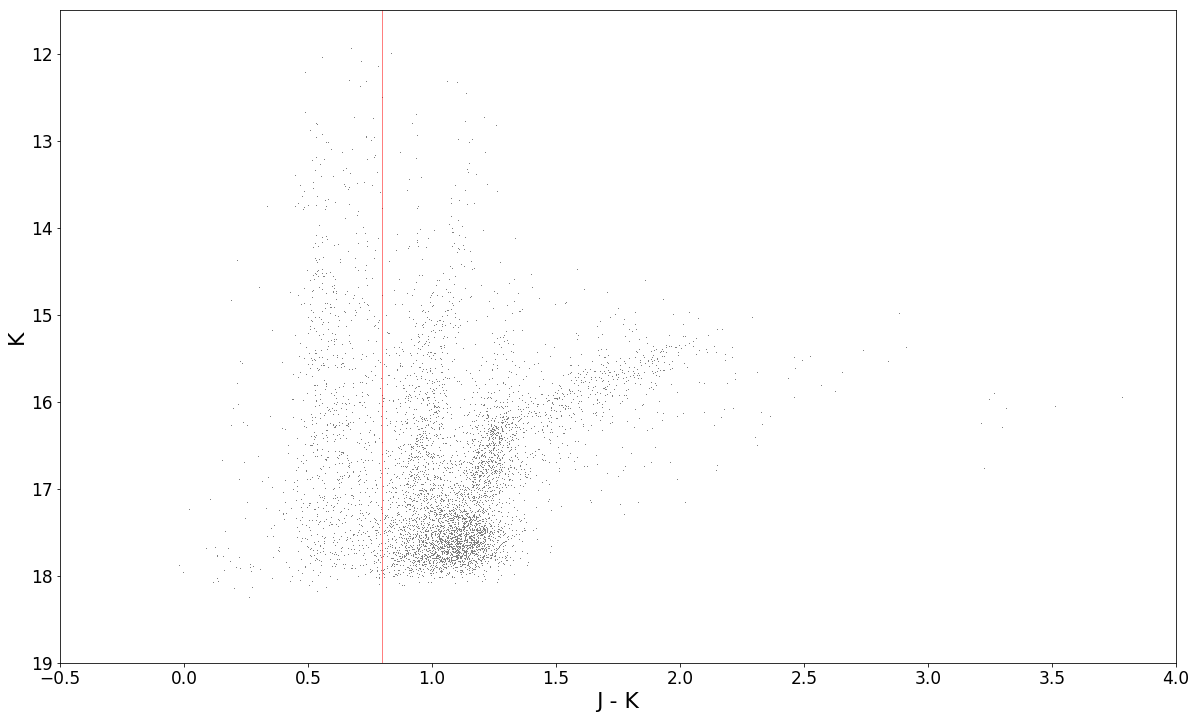

In [16]:
# check vertical line placement

plot_CMD(xaxis,yaxis)

plt.axvline(x=boundary, color='r', linewidth='0.5')

In [17]:
redlim = bound_shift(boundary)

print(redlim)

[nan, nan, nan, nan, 0.879895737662863, 0.8775924141636695, 0.8715707399707953, 0.8966725108531585, 0.9134534593651035, 0.9861642664403921, 0.8537197213938452, 0.8563514138914667, 0.8941956336486122, 0.9450078882716745, 0.8793135747862142, 0.8707045601520763, 0.8715208001858594, 0.8930588828268777, 0.8930080333111907, 0.8807308795514384, 0.8794535168895976, 0.9136080238527742, 0.8675755503981238, 0.8657623583369101, 0.881141593299356, 0.8869514024244964, 0.8923249691766746, 0.8656738054100351, 0.8697298533798425, 0.8958369977858692, 0.9002811788375211, 0.9182890033362764, 0.9048369520711795, 0.9213593947007497, 0.990804271229887, 0.9217934315691899, 0.9725898076646317, 0.9485478157675951, 0.971711498897255, 1.026288107882921, 1.0323488859538545, 1.0555758430921671, 1.0528741347386188, 1.0392519254971446, 1.0457953480186524, 1.0612945112049388, 1.0288953191907302, 1.0181779760618879, 1.0432569065443091, 1.012174119179027, 1.0212031855313928, 1.0246731251321948, 1.1041754291004438, 1.071

/Users/lgray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [18]:
# if you want to plot the flagged points in another color for visibility

red_x = []
red_y = []

k=0
for i in x_bin:
    c=0
    y_val = y_bin[k]
    for x in i:
        if x > redlim[k]:
            red_x.append(x)
            red_y.append(y_val[c])
            c=c+1
        else: 
            c=c+1
    k = k+1

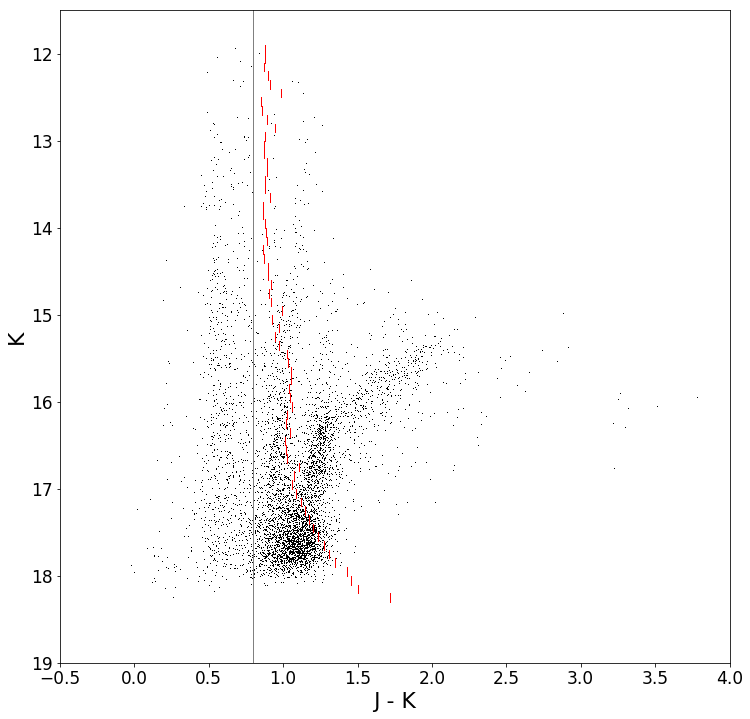

In [32]:
# Confirm shifted boundaries

plot_CMD(xaxis, yaxis, color='black')

if yaxis is eightzero:
    plt.axhline(y=15.4, linewidth=1, c='r')
    for x in redlim[:74]:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth='1')
        y1 = y1 + bin_size
else:
    for x in redlim:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth='1')
        y1 = y1 + bin_size

plt.axvline(x=boundary, color='grey', linewidth='1')
#plt.scatter(red_x, red_y, s=0.5, c='green') # plot flagged points in a different color

if yaxis is eightzero:
    y1 = 8.0
else:
    y1 = 11.5

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/3Aug2018/K_vs_J-K_3sig.pdf')

In [20]:
new_data = data_flag()
#print(new_data)

Number of flagged points: 1922


In [21]:
#save_data(new_data, column)